In [1]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string
import pandas as pd

import matplotlib
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
axis_font = {'size':'14','fontname':'Times New Roman'}

# Patch to fix the bold Times New Roman font 
# If you run this cell twice you will get an error, if that happens restart kernel
del matplotlib.font_manager.weight_dict['roman']
matplotlib.font_manager._rebuild()

# Patch to hide the x axis labels in two raw plot
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

# Heater simulation for tape 36

- The results from the heater experiments are plotted
- The heater used for these results is H2 located between sections V6 and V7.
- The peak voltages are choosen with the same time stamp where the voltage in V7 has its maximum value
- Transport current applied to the tape was 80 A. 
- Different voltage levels of the heater were used for each tape before and after the coating.

In [2]:
def T_gradient(x,Tmax):
    b = (77-Tmax)/24
    T = Tmax + b*x
    return T
    
def resistivity_vox(T):
    rho = (403.18-1.34*T)/100 # The resulting resistivity is in Ohm meters
    return rho

def resistivity_vox2(T,pf_LN,pf_RT): #allows to change the film resistivity at 77 K and RT
    rho = (((pf_RT-pf_LN)/223)*(T-77))+pf_LN # The resulting resistivity is in Ohm meters
    return rho

def resistivity_cu(T):
    rho_cu = (0.2E-8)+((1.48E-8)/223)*(T-77)
    return rho_cu

#rho = resistivity, l = length, w = width, tf = film thickness
def Rl_vox(rho,l,w,tf): 
    Rl = rho*l/(tf*w)
    return Rl
    
def Rt_vox(rho,l,w,tf):
    Rt = rho*tf/(l*w)
    return Rt

def Rcu_strip(rho,l,tc,w_cu):
    Rcu = rho*l/(tc*w_cu)
    return Rcu

def Rcu_stabilizer(rho,l,ts,w):
    Rs = rho*l/(ts*w)
    return Rs

def R_contact(rho,l,w_cu):
    Rc = rho/(l*w_cu)
    return Rc

def Ic(Ic_77,T):
    return Ic_77/13*(-T+90)

def Tc(Ic_77,I):
    return 90-I*13/Ic_77

def rho_cu_fromVI(V,I,w,t,l):
    rho = V*w*t/(I*l)
    return rho

def T_fromrho(rho_cu,rho_cu_77,rho_cu_RT):
    T = 77+(223*(rho_cu-rho_cu_77)/(rho_cu_RT-rho_cu_77))
    print('T before adjust', T)
    for i in range(len(T)):
        if T[i]<90:
            T[i] = 77
    return T



In [3]:
def generatingnetlist_cu(filename,Ic,n,Rs,Rc,Rcu,Imax): # Inputs netlist-name,critical current Ic, n values, stabilizer resistances,max input I
    
    # Printing the labels of the elements to read current for this case
    Labels = ['Index','i-sweep']
    
    # Voltage on top
    ns = 12
    for i in range(ns):
        Labels.append(f'v({i+2},{i+1})')
        #Labels.append(f'v({i+2})-v({i+1})')
    for i in range(ns):
        Labels.append(f'@rcu{i+1}[i]')
    for i in range(ns):
        Labels.append(f'@rs{i+1}[i]')
    for i in range(ns):
        Labels.append(f'@b{i+1}[i]')
    for i in range(ns+1):
        Labels.append(f'@rc{i+1}[i]')
    
    
    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    
    print(probe)
    
    # Constant Parameters for the model
    
    #n = 30 # n-value
    Ec = 100E-6 # Electric field criterion
    length = 6E-3 # [m] length of each section in sample holder
    Vc = Ec*length # Voltage criterion
    #Imax = 250 # Maximum current
    
    step = 20 # Step current
    Data_points = int(Imax/step + 1) # Data points calculated directly 
    
    # Start writing netlist
    with open(filename, 'w') as output:
        output.write(f'* Netlist for coating experiment\n')
        output.write('I1 0 S13 120\n') # Current source DC
        
        # Voltage sources
        output.write(f'B1 S2 0 V={Vc}*pow((I(B1)/{Ic[0]}),{n[0]})\n')
        output.write(f'B2 S3 S2 V={Vc}*pow((I(B2)/{Ic[1]}),{n[1]})\n')
        output.write(f'B3 S4 S3 V={Vc}*pow((I(B3)/{Ic[2]}),{n[2]})\n')
        output.write(f'B4 S5 S4 V={Vc}*pow((I(B4)/{Ic[3]}),{n[3]})\n')
        output.write(f'B5 S6 S5 V={Vc}*pow((I(B5)/{Ic[4]}),{n[4]})\n')
        output.write(f'B6 S7 S6 V={Vc}*pow((I(B6)/{Ic[5]}),{n[5]})\n')
        output.write(f'B7 S8 S7 V={Vc}*pow((I(B7)/{Ic[6]}),{n[6]})\n')
        output.write(f'B8 S9 S8 V={Vc}*pow((I(B8)/{Ic[7]}),{n[7]})\n')
        output.write(f'B9 S10 S9 V={Vc}*pow((I(B9)/{Ic[8]}),{n[8]})\n')
        output.write(f'B10 S11 S10 V={Vc}*pow((I(B10)/{Ic[9]}),{n[9]})\n')
        output.write(f'B11 S12 S11 V={Vc}*pow((I(B11)/{Ic[10]}),{n[10]})\n')
        output.write(f'B12 S13 S12 V={Vc}*pow((I(B12)/{Ic[11]}),{n[11]})\n')
        
        # Stabilizer resistances
        output.write(f'Rs1 S2 0 {Rs[0]}\n')
        output.write(f'Rs2 S3 S2 {Rs[1]}\n')
        output.write(f'Rs3 S4 S3 {Rs[2]}\n')
        output.write(f'Rs4 S5 S4 {Rs[3]}\n')
        output.write(f'Rs5 S6 S5 {Rs[4]}\n')
        output.write(f'Rs6 S7 S6 {Rs[5]}\n')
        output.write(f'Rs7 S8 S7 {Rs[6]}\n')
        output.write(f'Rs8 S9 S8 {Rs[7]}\n')
        output.write(f'Rs9 S10 S9 {Rs[8]}\n')
        output.write(f'Rs10 S11 S10 {Rs[9]}\n')
        output.write(f'Rs11 S12 S11 {Rs[10]}\n')
        output.write(f'Rs12 S13 S12 {Rs[11]}\n')
        
        # Cu strip resistances
        output.write(f'Rcu1 2 1 {Rcu[0]}\n')
        output.write(f'Rcu2 3 2 {Rcu[1]}\n')
        output.write(f'Rcu3 4 3 {Rcu[2]}\n')
        output.write(f'Rcu4 5 4 {Rcu[3]}\n')
        output.write(f'Rcu5 6 5 {Rcu[4]}\n')
        output.write(f'Rcu6 7 6 {Rcu[5]}\n')
        output.write(f'Rcu7 8 7 {Rcu[6]}\n')
        output.write(f'Rcu8 9 8 {Rcu[7]}\n')
        output.write(f'Rcu9 10 9 {Rcu[8]}\n')
        output.write(f'Rcu10 11 10 {Rcu[9]}\n')
        output.write(f'Rcu11 12 11 {Rcu[10]}\n')
        output.write(f'Rcu12 13 12 {Rcu[11]}\n')
        
        # Contact resistances
        output.write(f'Rc1 1 0 {Rc[0]}\n')
        output.write(f'Rc2 2 S2 {Rc[1]}\n')
        output.write(f'Rc3 3 S3 {Rc[2]}\n')
        output.write(f'Rc4 4 S4 {Rc[3]}\n')
        output.write(f'Rc5 5 S5 {Rc[4]}\n')
        output.write(f'Rc6 6 S6 {Rc[5]}\n')
        output.write(f'Rc7 7 S7 {Rc[6]}\n')
        output.write(f'Rc8 8 S8 {Rc[6]}\n')
        output.write(f'Rc9 9 S9 {Rc[7]}\n')
        output.write(f'Rc10 10 S10 {Rc[8]}\n')
        output.write(f'Rc11 11 S11 {Rc[9]}\n')
        output.write(f'Rc12 12 S12 {Rc[10]}\n')
        output.write(f'Rc13 13 S13 {Rc[11]}\n')
        
        output.write(f'.dc I1 0 {Imax} {step}\n')
        output.write('.print dc '+probe+'\n')
        output.write('.end\n')
    return Labels,Data_points

In [4]:
# This definition is used to run the netlist in ngspice and load the data generated by the program. 

def readdata(filename,Data_points):
    Labels = ['Index','i-sweep']
    ns = 12
    for i in range(ns):
        Labels.append(f'v({i+2})-v({i+1})')
    
    for i in range(ns):
        Labels.append(f'@rcu{i+1}[i]')
    
    for i in range(ns):
        Labels.append(f'@rs{i+1}[i]')
        
    for i in range(ns):
        Labels.append(f'@b{i+1}[i]')
    
    for i in range(ns+1):
        Labels.append(f'@rc{i+1}[i]')
        
    #print('Labels',Labels)
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)
    data = np.zeros ([Data_points, len(Labels)])
    
    flag = False
    for line in src:
        #print(line)
        # Here we initialize the ngspice data array
        '''
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)
        '''
        
        
        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            flag = True
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len(temp_list)
            #print('n_columns\n',n_columns)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if flag == True: # Only if the first index has passed for the ac analysis
            if line[0].isdigit():
                temp_data = [float(x) for x in line.split()]

                for c in range(n_columns):
                    r = fill[c]

                    data [r][index[c]] = temp_data [c]
                    fill [c] = fill [c] + 1
                    if fill [c] == Data_points:
                        fill [c] = 0
    return data

In [5]:
def read_file(filename):
    with open(filename) as f:
        lines_after_first = f.readlines()[1:]
        data = []
        for line in lines_after_first:
            tmp = [float(x) for x in line.split('\t')]
            data.append(tmp)
    data = np.asanyarray(data)
    return data[-1][1:]

def current_profile(data): # This definition returns the calculated voltage profile
    Icu_profile = []
    for i in range(12):
        Icu = data[:,2+12+i]
        Icu_profile.append(Icu[-1])
    Icu_profile = np.array(Icu_profile) 
    
    Is_profile = []
    for i in range(12):
        Is = data[:,2+2*12+i]
        #print(f'Is{i}',Is)
        Is_profile.append(Is[-1])
        
    Is_profile = np.array(Is_profile) 
    #print('Is profile', Is_profile)
    
    Ihts_profile = []
    for i in range(12):
        Ihts = data[:,2+3*12+i]
        Ihts_profile.append(Ihts[-1])
    Ihts_profile = np.array(Ihts_profile) 
    
    Irc_profile = []
    for i in range(13):
        Irc = data[:,2+4*12+i]
        Irc_profile.append(Irc[-1])
    Irc_profile = np.array(Irc_profile) 
    
    
    return Icu_profile,Is_profile,Ihts_profile,Irc_profile

In [6]:
def resistances_model(Imax,V_max,Ic_t,n_t): # Resistances that we input in the NGspice model
    # Geometry values
    l = 6E-3 # [m] Distance between pins for voltage taps
    w = 4E-3 # [m] Width of the tape
    w_cu = 4E-3 # [m] Width of cu strip
    tf = 0.5E-6 # [m] Thickness of the VO film
    tc = 0.29E-3 # [m] Thickness of Cu tape on top 
    ts = 40E-6 # [m] Thickness of the Cu stabilizer in ReBCO tape 

    pf_LN = 0.12 # [Ohm m] VOx resistivity at 77 K (VALUE FOR TAPE 26)
    pf_RT = 0.01 # [Ohm m] VO resitivity at room temperature ~ 294 K

    pcu_RT = 1.68E-8 # [Ohm m] Cu resistivity 1.68E-8 at 300 K
    pcu_LN = 0.2E-8 # [Ohm m] Cu resistivity 77 K

    # Temperature profile based on measured data
    rho_cu2 = rho_cu_fromVI(V_max,Imax,w,tc,l)
    T = T_fromrho(rho_cu2,pcu_LN,pcu_RT)
    
    # Cu strip resistances
    rho_cu = resistivity_cu(T)
    Rcu = Rcu_strip(rho_cu,l,tc,w)
    
    # VOx resistances
    rho_vox = resistivity_vox2(T,pf_LN,pf_RT)
    Rl = Rl_vox(rho_vox,l,w,tf)
    Rt = Rt_vox(rho_vox,l,w,tf)
    
    Rs = Rcu_stabilizer(rho_cu,l,ts,w) # Stabilizer resistances
    Rc = np.zeros(12)+85E-6 # Contact resistances 85E-6 was calculated from tape 26
    
    # Critical current and n values
    Ic = np.zeros(12)+0.001  # 0.001 is a minimum value that we used to treat the voltage sources as non superconductive
    n = np.zeros(12)+n_t
    for i in range(12):
        if T[i] == 77:
            Ic[i]= Ic_t
    return Ic,n,Rs,Rc,Rcu,Rt,T


In [7]:
# Using stabilizer of 50um per layer given the 150 um thickness measured in the HTS tape

def resistances_model2(Imax,V_max,Ic_t,n_t): # Resistances that we input in the NGspice model
    # Geometry values
    l = 6E-3 # [m] Distance between pins for voltage taps
    w = 4E-3 # [m] Width of the tape
    w_cu = 4E-3 # [m] Width of cu strip
    tf = 0.5E-6 # [m] Thickness of the VO film
    tc = 0.29E-3 # [m] Thickness of Cu tape on top 
    ts = 100E-6 # [m] Thickness of the Cu stabilizer in ReBCO tape 

    pf_LN = 0.12 # [Ohm m] VOx resistivity at 77 K (VALUE FOR TAPE 26)
    pf_RT = 0.01 # [Ohm m] VO resitivity at room temperature ~ 294 K

    pcu_RT = 1.68E-8 # [Ohm m] Cu resistivity 1.68E-8 at 300 K
    pcu_LN = 0.2E-8 # [Ohm m] Cu resistivity 77 K

    # Temperature profile based on measured data
    rho_cu2 = rho_cu_fromVI(V_max,Imax,w,tc,l)
    T = T_fromrho(rho_cu2,pcu_LN,pcu_RT)
    
    # Cu strip resistances
    rho_cu = resistivity_cu(T)
    Rcu = Rcu_strip(rho_cu,l,tc,w)
    
    # VOx resistances
    rho_vox = resistivity_vox2(T,pf_LN,pf_RT)
    Rl = Rl_vox(rho_vox,l,w,tf)
    Rt = Rt_vox(rho_vox,l,w,tf)
    
    Rs = Rcu_stabilizer(rho_cu,l,ts,w) # Stabilizer resistances
    Rc = np.zeros(12)+85E-6 # Contact resistances 85E-6 was calculated from tape 26
    
    # Critical current and n values
    Ic = np.zeros(12)+0.001  # 0.001 is a minimum value that we used to treat the voltage sources as non superconductive
    n = np.zeros(12)+n_t
    for i in range(12):
        if T[i] == 77:
            Ic[i]= Ic_t
    return Ic,n,Rs,Rc,Rcu,Rt,T


# Definition to generate the resistances given the temperature profile
def resistances_modelT(T,Ic_t,n_t): # Resistances that we input in the NGspice model
    # Geometry values
    l = 6E-3 # [m] Distance between pins for voltage taps
    w = 4E-3 # [m] Width of the tape
    w_cu = 4E-3 # [m] Width of cu strip
    tf = 0.5E-6 # [m] Thickness of the VO film
    tc = 0.29E-3 # [m] Thickness of Cu tape on top 
    ts = 100E-6 # [m] Thickness of the Cu stabilizer in ReBCO tape 

    pf_LN = 0.12 # [Ohm m] VOx resistivity at 77 K (VALUE FOR TAPE 26)
    #pf_LN = 3
    pf_RT = 0.01 # [Ohm m] VO resitivity at room temperature ~ 294 K

    pcu_RT = 1.68E-8 # [Ohm m] Cu resistivity 1.68E-8 at 300 K
    pcu_LN = 0.2E-8 # [Ohm m] Cu resistivity 77 K

    # Temperature profile based on measured data
    #rho_cu2 = rho_cu_fromVI(V_max,Imax,w,tc,l)
    #T = T_fromrho(rho_cu2,pcu_LN,pcu_RT)
    #T = np.array([77,77,77,77,77,77,77,77,77,77,77,77])
    
    # Cu strip resistances
    rho_cu = resistivity_cu(T)
    Rcu = Rcu_strip(rho_cu,l,tc,w)
    
    # VOx resistances
    rho_vox = resistivity_vox2(T,pf_LN,pf_RT)
    Rl = Rl_vox(rho_vox,l,w,tf)
    Rt = Rt_vox(rho_vox,l,w,tf)
    
    Rs = Rcu_stabilizer(rho_cu,l,ts,w) # Stabilizer resistances
    Rc = np.zeros(12)+85E-6 # Contact resistances 85E-6 was calculated from tape 26
    
    # Critical current and n values
    Ic = np.zeros(12)+0.001  # 0.001 is a minimum value that we used to treat the voltage sources as non superconductive
    n = np.zeros(12)+n_t
    for i in range(12):
        if T[i] <= 77:
            Ic[i]= Ic_t
    return Ic,n,Rs,Rc,Rcu,Rt,T

In [8]:
# This defition is made to analyse the data from the heater experiment 
# This definition can analyze one or more files, filenumber is used to create a txt file with the results or add results


def heater_csv(file_csv,tape_number,Vheater,filenumber,current_percent,filename,coating):
    # Data base for the file without coating
    data_ic_wo = pd.read_csv(file_csv)
    #time_ic_wo = data_ic_wo['time']
    last_index = len(data_ic_wo['v7_m'])
    stop = (last_index)*(0.19984)
    time_ic_wo = np.arange(0,stop,0.19984)
    
    # For loop to print the voltages from the 12 sections
    #fig,ax = plt.subplots() # uncomment if you need plots from experiment
    for i in range(12): 
        v_wo = np.asarray(data_ic_wo[f'v{i+1}_m'])
        # Uncomment the next part if you need the plots from experiment
        #ax.plot(time_ic_wo,(v_wo-v_wo[0])/1e-3,label = f'V{i+1}')
    ''' uncomment if you need plots from experiments
    ax.set_xlabel('Time (s)',**axis_font)
    ax.set_ylabel('Voltage (mV)',**axis_font)
    ax.set_ylim(-1,7)
    ax.legend(labelspacing=0.001,ncol=1,loc='upper right',prop={'size':10}) 
    ax.grid()

    ax2 = ax.twinx()
    ax2.plot(time_ic_wo,data_ic_wo['T2_m'],'--k')
    ax2.set_ylabel('Temperature (K)',**axis_font)
    ax2.set_ylim(70,450)
    plt.title(f'Tape {tape_number} '+coating+f' VOx coating {current_percent} A, heater {Vheater} V',**axis_font)
    plt.tight_layout()
    plt.show()
    '''
    max_T, max_index =  max(data_ic_wo['v7_m']), np.where(data_ic_wo['v7_m'] == max(data_ic_wo['v7_m']))[0][0]
    print(f'V_heater',Vheater,': Max V7 =',max_T,'V, index',max_index)

    #filename = f'Tape {tape_number} heater {current_percent} A peak voltages without coating.txt'
    
    if filenumber<1:
        max_V = []
        for i in range(12):
            v_wo = np.asarray(data_ic_wo[f'v{i+1}_m'])
            max_V.append(v_wo[max_index]-v_wo[0]) # maximum voltage independent of the temperature
        max_V = np.array(max_V)
        #print(max_V)
        # Saving data from average and sd arrays
        with open(filename, 'w') as output:
            output.write('V1\t V2\t V3\t V4\t V5\t V6\t V7\t V8\t V9\t V10\t V11\t V12\t coating\t heater_v\n')
            for elements in max_V:
                 output.write(str(elements))
                 output.write('\t') 
            output.write(f'{Vheater}\n')
    else:
        max_V = []
        for i in range(12):
            v_wo = np.asarray(data_ic_wo[f'v{i+1}_m'])
            max_V.append(v_wo[max_index]-v_wo[0]) # maximum voltage independent of the temperature
        max_V = np.array(max_V)
        #print(max_V)
        # Saving data from average and sd arrays
        #filename = f'Tape {tape_number} heater {current_percent} peak voltages without coating.txt'
        with open(filename, 'a') as output:
            #output.write('V1\t V2\t V3\t V4\t V5\t V6\t V7\t V8\t V9\t V10\t V11\t V12\t coating\t heater_v\n')
            for elements in max_V:
                 output.write(str(elements))
                 output.write('\t') 
            output.write(f'{Vheater}\n')
    return max_V

In [9]:
# This definition was created to plot data where there is no heater, but you can select any time stamp with max_index

def noheater_csv(file_csv,tape_number,Vheater,filenumber,current_percent,filename,coating,max_index):
    # Data base for the file without coating
    data_ic_wo = pd.read_csv(file_csv)
    #time_ic_wo = data_ic_wo['time']
    last_index = len(data_ic_wo['v7_m'])
    stop = (last_index)*(0.19984)
    time_ic_wo = np.arange(0,stop,0.19984)
    
    # For loop to print the voltages from the 12 sections
    #fig,ax = plt.subplots() # uncomment if you need plots from experiment
    for i in range(12): 
        v_wo = np.asarray(data_ic_wo[f'v{i+1}_m'])
        # Uncomment the next part if you need the plots from experiment
        #ax.plot(time_ic_wo,(v_wo-v_wo[0])/1e-3,label = f'V{i+1}')
    ''' uncomment if you need plots from experiments
    ax.set_xlabel('Time (s)',**axis_font)
    ax.set_ylabel('Voltage (mV)',**axis_font)
    ax.set_ylim(-1,7)
    ax.legend(labelspacing=0.001,ncol=1,loc='upper right',prop={'size':10}) 
    ax.grid()

    ax2 = ax.twinx()
    ax2.plot(time_ic_wo,data_ic_wo['T2_m'],'--k')
    ax2.set_ylabel('Temperature (K)',**axis_font)
    ax2.set_ylim(70,450)
    plt.title(f'Tape {tape_number} '+coating+f' VOx coating {current_percent} A, heater {Vheater} V',**axis_font)
    plt.tight_layout()
    plt.show()
    '''
    #max_T, max_index =  max(data_ic_wo['v7_m']), np.where(data_ic_wo['v7_m'] == max(data_ic_wo['v7_m']))[0][0]
    #print(f'V_heater',Vheater,': Max V7 =',max_T,'V, index',max_index)

    #filename = f'Tape {tape_number} heater {current_percent} A peak voltages without coating.txt'
    
    if filenumber<1:
        max_V = []
        for i in range(12):
            v_wo = np.asarray(data_ic_wo[f'v{i+1}_m'])
            max_V.append(v_wo[max_index]-v_wo[0]) # maximum voltage independent of the temperature
        max_V = np.array(max_V)
        #print(max_V)
        # Saving data from average and sd arrays
        with open(filename, 'w') as output:
            output.write('V1\t V2\t V3\t V4\t V5\t V6\t V7\t V8\t V9\t V10\t V11\t V12\t coating\t heater_v\n')
            for elements in max_V:
                 output.write(str(elements))
                 output.write('\t') 
            output.write(f'{Vheater}\n')
    else:
        max_V = []
        for i in range(12):
            v_wo = np.asarray(data_ic_wo[f'v{i+1}_m'])
            max_V.append(v_wo[max_index]-v_wo[0]) # maximum voltage independent of the temperature
        max_V = np.array(max_V)
        #print(max_V)
        # Saving data from average and sd arrays
        #filename = f'Tape {tape_number} heater {current_percent} peak voltages without coating.txt'
        with open(filename, 'a') as output:
            #output.write('V1\t V2\t V3\t V4\t V5\t V6\t V7\t V8\t V9\t V10\t V11\t V12\t coating\t heater_v\n')
            for elements in max_V:
                 output.write(str(elements))
                 output.write('\t') 
            output.write(f'{Vheater}\n')
    return max_V

In [10]:
def voltage_profile(data): # This definition returns the calculated voltage profile
    v_profile = []
    for i in range(12):
        v = data[:,2+i]
        v_profile.append(v[-1])
    v_profile = np.array(v_profile) 
    return v_profile

# CSV files for tape 36

This files can be found in https://drive.google.com/drive/u/1/folders/1phgAL6iFXIMr5-pkR8zoDFWea2H-A7QM

'''
Files without coating tape 36
Vheater = [6,7,8,8,8.5,8.5]
[
'tape36_w_cu_thin_2020-02-10-16-10-57.csv',
'tape36_w_cu_thin_2020-02-10-17-21-44.csv',
'tape36_w_cu_thin_2020-02-10-15-47-46.csv',
'tape36_w_cu_thin_2020-02-10-16-00-54.csv',
'tape36_w_cu_thin_2020-02-10-15-24-38.csv',
'tape36_w_cu_thin_2020-02-10-15-37-11.csv'
]

Files with coating for tape 36
Vheater = [6,6,7,7,8,8,8.5,8.5]
file_csv = [
'tape36_w_cu_coating_2020-02-12-13-36-18.csv',
'tape36_w_cu_coating_2020-02-12-13-49-37.csv',
'tape36_w_cu_coating_2020-02-12-14-01-48.csv',
'tape36_w_cu_coating_2020-02-12-14-15-24.csv',
'tape36_w_cu_coating_2020-02-12-14-30-05.csv',
'tape36_w_cu_coating_2020-02-12-14-53-43.csv',
'tape36_w_cu_coating_2020-02-12-15-22-52.csv',
'tape36_w_cu_coating_2020-02-12-15-46-46.csv'
]


'''

# Using 100 um thick stabilizer and analytic temperature profile

V_heater 8.5 : Max V7 = 0.0055683980000000004 V, index 372
V_heater 8.5 : Max V7 = 0.00441792 V, index 418
v(2,1) v(3,2) v(4,3) v(5,4) v(6,5) v(7,6) v(8,7) v(9,8) v(10,9) v(11,10) v(12,11) v(13,12) @rcu1[i] @rcu2[i] @rcu3[i] @rcu4[i] @rcu5[i] @rcu6[i] @rcu7[i] @rcu8[i] @rcu9[i] @rcu10[i] @rcu11[i] @rcu12[i] @rs1[i] @rs2[i] @rs3[i] @rs4[i] @rs5[i] @rs6[i] @rs7[i] @rs8[i] @rs9[i] @rs10[i] @rs11[i] @rs12[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i] @b7[i] @b8[i] @b9[i] @b10[i] @b11[i] @b12[i] @rc1[i] @rc2[i] @rc3[i] @rc4[i] @rc5[i] @rc6[i] @rc7[i] @rc8[i] @rc9[i] @rc10[i] @rc11[i] @rc12[i] @rc13[i] 
v(2,1) v(3,2) v(4,3) v(5,4) v(6,5) v(7,6) v(8,7) v(9,8) v(10,9) v(11,10) v(12,11) v(13,12) @rcu1[i] @rcu2[i] @rcu3[i] @rcu4[i] @rcu5[i] @rcu6[i] @rcu7[i] @rcu8[i] @rcu9[i] @rcu10[i] @rcu11[i] @rcu12[i] @rs1[i] @rs2[i] @rs3[i] @rs4[i] @rs5[i] @rs6[i] @rs7[i] @rs8[i] @rs9[i] @rs10[i] @rs11[i] @rs12[i] @b1[i] @b2[i] @b3[i] @b4[i] @b5[i] @b6[i] @b7[i] @b8[i] @b9[i] @b10[i] @b11[i] @b12[i] @rc1[i] 

<IPython.core.display.Javascript object>


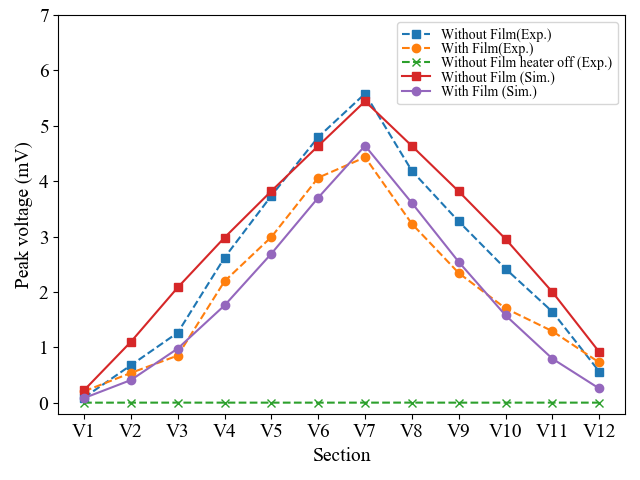

In [11]:
tape_number = 36
current_percent = 80
filename_wo = f'Tape {tape_number} heater {current_percent} A peak voltages without coating model.txt'
filename_w = f'Tape {tape_number} heater {current_percent} A peak voltages with coating model.txt'

filenumber = 0 # This indicates that there is only one file to analyze
Vheater = 8.5 # Maximum voltage input to the heater
file_csv_wo = 'tape36_w_cu_thin_2020-02-10-15-37-11.csv' # Heater test without coating
file_csv_w = 'tape36_w_cu_coating_2020-02-12-15-22-52.csv' # Heater test with coating 

# Read experimental data from csv and get the peak voltage profile
V_max_wo = heater_csv(file_csv_wo,tape_number,Vheater,filenumber,current_percent,filename_wo,'wo')
V_max_w = heater_csv(file_csv_w,tape_number,Vheater,filenumber,current_percent,filename_w,'w')

V_noheater = noheater_csv(file_csv_wo,tape_number,Vheater,filenumber,current_percent,filename_wo,'wo',100)

# File names of the ngspice netlists 
filename_wo = 'Heater_wo_t36_VOx_8_5V_Tpower.cir' # Without coating
filename_w = 'Heater_w_t36_VOx_8_5V_Tpower.cir' # With coating

Imax = 80 # A Transport current for this case 
# Ic and n for tape 36 at 77 K
Ic_t = 97.82
n_t = 33.16


# Analytic temperature profile heat from V4 to V10
#T_power_w = np.array([77,77,77,134.2135417,191.4270833,248.640625,305.8541667,248.640625,191.4270833,134.2135417,77,77])
#T_power_wo = np.array([77,77,77,136.1145833,195.2291667,254.34375,313.4583333,254.34375,195.2291667,136.1145833,77,77])                     

# Analytic temperature profile heat from v2-v12, used for manuscript
T_power_wo = np.array([77,116.4097222,155.8194444,195.2291667,234.6388889,274.0486111,313.4583333,274.0486111,234.6388889,195.2291667,155.8194444,116.4097222])
T_power_w = np.array([77,115.1423611,153.2847222,191.4270833,229.5694444,267.7118056,305.8541667,267.7118056,229.5694444,191.4270833,153.2847222,115.1423611])


# NGspice for the case without coating
Ic,n,Rs_wo,Rc_wo,Rcu_wo,Rt_wo,T_wo = resistances_modelT(T_power_wo,Ic_t,n_t) # Calculate resistances for netlist
Labels,Data_points = generatingnetlist_cu(filename_wo,Ic,n,Rs_wo,Rc_wo,Rcu_wo,Imax) # Create netlist
data_wo = readdata(filename_wo,Data_points) # Run ngspie and get voltage and currents
v_wo = voltage_profile(data_wo) # Get peak voltages from ngspice
I_cu_wo,Is_wo,Ihts_wo,Irc_wo = current_profile(data_wo) # Get current distribution

# Ngspice data for the case with coating
Ic,n,Rs_w,Rc_w,Rcu_w,Rt_w,T_w = resistances_modelT(T_power_w,Ic_t,n_t)
Labels,Data_points = generatingnetlist_cu(filename_w,Ic,n,Rs_w,2*Rc_w+Rt_w,Rcu_w,Imax) # In the Rc input we add the Rt from coating
data_w = readdata(filename_w,Data_points)
v_w = voltage_profile(data_w)
I_cu_w,Is_w,Ihts_w,Irc_w = current_profile(data_w)


%matplotlib notebook 

section = np.arange(12)

labels = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12']

#w_t36 = read_file('w_t36.txt') VIP files
#wo_t36 = read_file('wo_t36.txt') VIP files

# Changing labels of the x axis
plt.xticks(section,labels,**axis_font)
plt.yticks(**axis_font)

plt.plot(section,V_max_wo/1e-3,'--s',label = 'Without Film(Exp.)')
plt.plot(section,V_max_w/1e-3,'--o',label = 'With Film(Exp.)')
plt.plot(section,V_noheater/1e-3,'--x',label = 'Without Film heater off (Exp.)')

plt.plot(section,v_wo/1e-3,'-s',label = 'Without Film (Sim.)')
plt.plot(section,v_w/1e-3,'-o',label = 'With Film (Sim.)')


plt.xlabel('Section',**axis_font)
plt.ylabel('Peak voltage (mV)',**axis_font)
#plt.title('Transport current 80 A, Heater voltage 8.5 V',**axis_font)
plt.legend(labelspacing=0.001,ncol=1,loc='best',prop={'family':'Times New Roman', 'size':10}) 
plt.tight_layout()
#plt.grid()
plt.ylim(-0.2,7)
plt.savefig(f'sim_t{tape_number}_{Vheater}_100e-6m_analyticT.png')
plt.show()

<IPython.core.display.Javascript object>


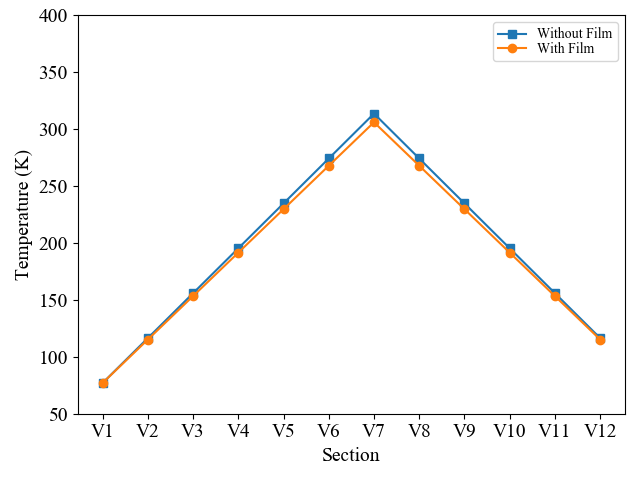

In [12]:
# Plot temperature profiles
%matplotlib notebook 

section = np.arange(12)

labels = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12']
plt.xticks(section,labels,**axis_font)
plt.yticks(**axis_font)

plt.plot(section,T_power_wo,'-s',label = 'Without Film')
plt.plot(section,T_power_w,'-o',label = 'With Film')

plt.xlabel('Section',**axis_font)
plt.ylabel('Temperature (K)',**axis_font)
#plt.title(f'Temperature profile',**axis_font)
plt.legend(labelspacing=0.001,ncol=1,loc='best',prop={'family':'Times New Roman', 'size':10}) 
plt.tight_layout()
#plt.grid()
plt.ylim(50,400)
plt.savefig(f'Tprof_t{tape_number}_{Vheater}_analyticT.png')
plt.show()

<IPython.core.display.Javascript object>


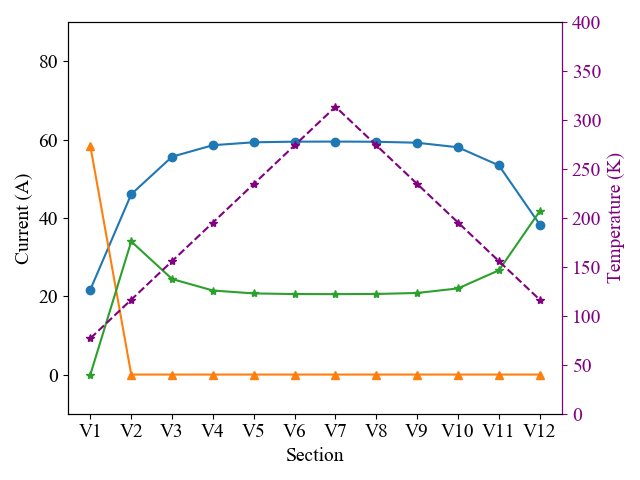

In [13]:
#Plot current distribution in HTS voltage source, Rcu, Rs without coating
%matplotlib notebook 


section = np.arange(12)

labels = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12']


fig,ax = plt.subplots()
ax.set_xticks(section)
ax.set_xticklabels(labels,**axis_font)


plt.yticks(**axis_font)

ax.plot(section,I_cu_wo,'-o',label = '$I_{Rcu}$')
#plt.plot(section,I_cu_w,'-o',label = f'I_Rcu w_VOx')


ax.plot(section,Ihts_wo,'-^',label = '$I_{HTS}$')
#plt.plot(section,Ihts_w,'-^',label = f'I_hts w_VOx')

ax.plot(section,Is_wo,'-*',label = '$I_{Rs}$')
#plt.plot(section,Is_w,'-*',label = f'I_s w_VOx')

ax.set_ylim(-10,90)
ax.set_xlabel('Section',**axis_font)
ax.set_ylabel('Current (A)',**axis_font)
#plt.title('Current distribution without coating, $I_{transport}$ = 80 A',**axis_font)
#ax.legend(labelspacing=0.001,ncol=1,loc='best',prop={'family':'Times New Roman', 'size':10}) 

ax2 = ax.twinx()
ax2.plot(section,T_power_wo,'--*',color='purple')
ax2.set_ylabel('Temperature (K)',**axis_font)
ax2.spines['right'].set_color('purple')
ax2.tick_params(axis='y', colors='purple')
ax2.yaxis.label.set_color('purple')

ax2.set_ylim(0,400)
plt.yticks(**axis_font)

plt.tight_layout()
#plt.grid()
plt.savefig(f'wo_currents_t36_100e-6m_analyticT.png')
plt.show()

<IPython.core.display.Javascript object>


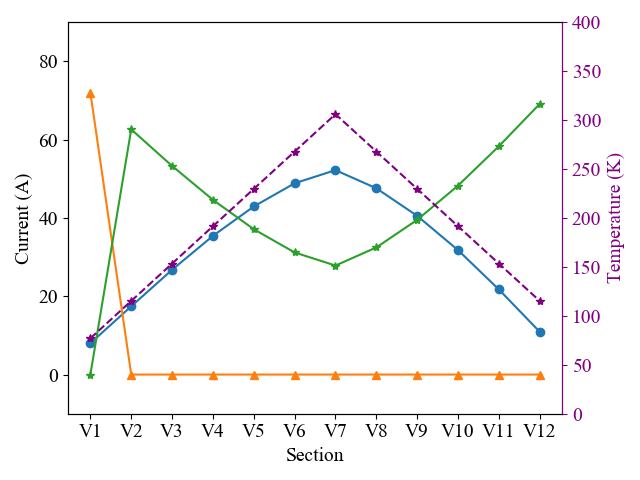

In [14]:
#Plot current distribution in HTS voltage source, Rcu, Rs with coating
%matplotlib notebook 

section = np.arange(12)

labels = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12']

fig,ax = plt.subplots()
ax.set_xticks(section)
ax.set_xticklabels(labels,**axis_font)
plt.yticks(**axis_font)


#plt.plot(section,I_cu_wo,'-o',label = 'I_Rcu without VOx')
ax.plot(section,I_cu_w,'-o',label = '$I_{Rcu}$')


#plt.plot(section,Ihts_wo,'-^',label = 'I_hts without VOx')
ax.plot(section,Ihts_w,'-^',label = '$I_{HTS}$')

#plt.plot(section,Is_wo,'-*',label = 'I_s without VOx')
ax.plot(section,Is_w,'-*',label = '$I_{Rs}$')

#plt.ylim(-2,40)

ax.set_ylim(-10,90)
ax.set_xlabel('Section',**axis_font)
ax.set_ylabel('Current (A)',**axis_font)
#plt.title('Current distribution with coating, $I_{transport}$ = 80 A',**axis_font)
#ax.legend(labelspacing=0.001,ncol=1,loc='best',prop={'family':'Times New Roman', 'size':10}) 

ax2 = ax.twinx()
ax2.plot(section,T_power_w,'--*',color='purple')
ax2.set_ylabel('Temperature (K)',**axis_font)
ax2.spines['right'].set_color('purple')
ax2.tick_params(axis='y', colors='purple')
ax2.yaxis.label.set_color('purple')

ax2.set_ylim(0,400)
plt.yticks(**axis_font)



plt.tight_layout()
#plt.grid()
plt.savefig(f'w_currents_t36_100e-6m_analyticT.png')
plt.show()

<IPython.core.display.Javascript object>


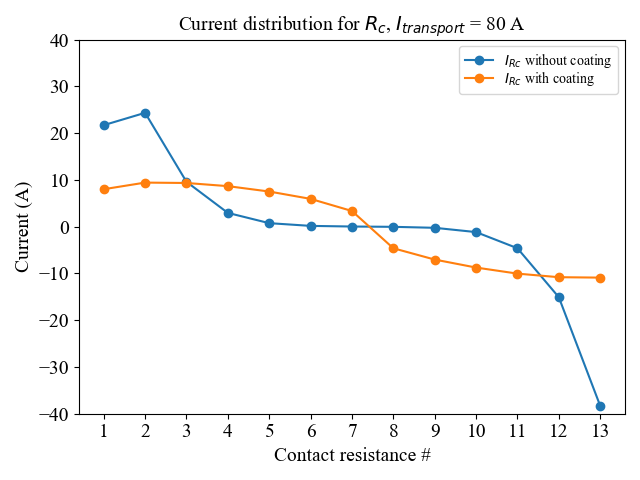

In [15]:
# Plot current distribution in Rc with and without coating

%matplotlib notebook 

section = np.arange(13)

labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13']

plt.xticks(section,labels,**axis_font)
plt.yticks(**axis_font)
#plt.plot(section,Irc_77,'-o',label = f'I_rc wo_VOx at 77 k') 

plt.plot(section,Irc_wo,'-o',label = '$I_{Rc}$ without coating')

plt.plot(section,Irc_w,'-o',label = '$I_{Rc}$ with coating')

plt.ylim(-40,40)
plt.xlabel('Contact resistance #',**axis_font)
plt.ylabel('Current (A)',**axis_font)
plt.title('Current distribution for $R_c$, $I_{transport}$ = 80 A',**axis_font)
plt.legend(labelspacing=0.001,ncol=1,loc='best',prop={'family':'Times New Roman', 'size':10}) 
plt.tight_layout()
#plt.grid()
plt.savefig(f'w_currents_rc_t36_100e-6m_analyticT.png')
plt.show()

<IPython.core.display.Javascript object>


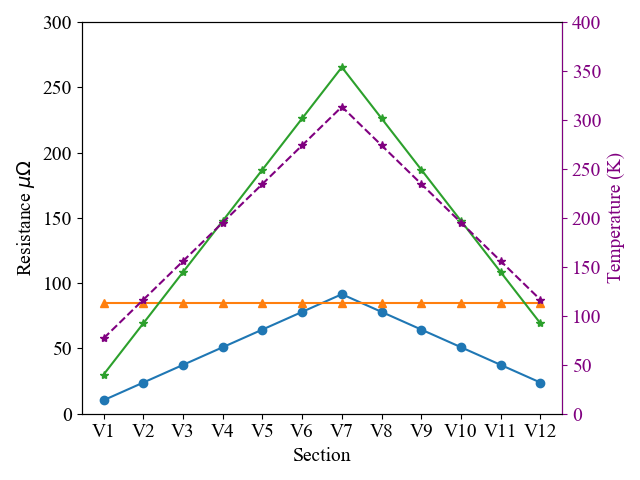

In [16]:
#Plotting resistances used in the circuit for the case without coating

section = np.arange(12)

labels = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12']
#plt.xticks(section,labels)


%matplotlib notebook 

fig,ax = plt.subplots()
ax.set_xticks(section)
ax.set_xticklabels(labels,**axis_font)

ax.plot(section,Rcu_wo/1e-6,'-o',label = '$R_{cu}$')
ax.plot(section,Rc_wo/1e-6,'-^',label = '$R_c$')
ax.plot(section,Rs_wo/1e-6,'-*',label = '$R_s$')

ax.set_xlabel('Section',**axis_font)
ax.set_ylabel('Resistance $\mu\Omega$',**axis_font)
ax.set_ylim(0,300)
#ax.legend(labelspacing=0.001,ncol=1,loc='upper right',prop={'size':10}) 
#ax.grid()
plt.yticks(**axis_font)

ax2 = ax.twinx()
ax2.plot(section,T_power_wo,'--*',color='purple')
ax2.set_ylabel('Temperature (K)',**axis_font)
ax2.spines['right'].set_color('purple')
ax2.tick_params(axis='y', colors='purple')
ax2.yaxis.label.set_color('purple')

ax2.set_ylim(0,400)
plt.yticks(**axis_font)
#plt.title(f'Circuit parameters without coating',**axis_font)
plt.tight_layout()
plt.savefig(f'wo_circuitparameters_analyticT.png')
plt.show()


<IPython.core.display.Javascript object>


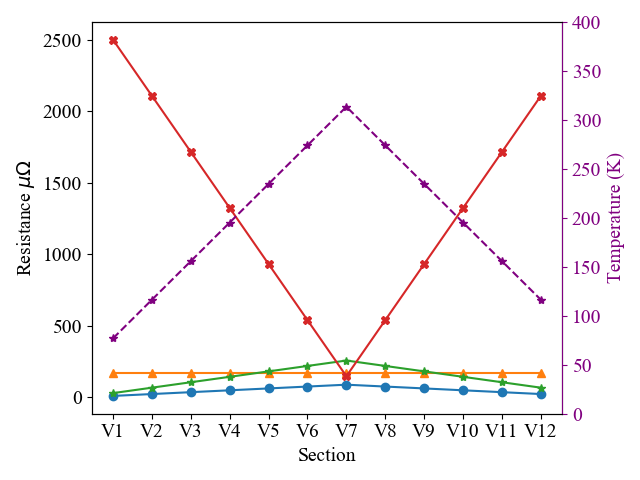

In [17]:
#Plotting resistances used in the circuit for the case with coating

section = np.arange(12)

labels = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12']


%matplotlib notebook 

fig,ax = plt.subplots()


ax.plot(section,Rcu_w/1e-6,'-o',label = '$R_{cu}$')
ax.plot(section,2*Rc_w/1e-6,'-^',label = '$R_c$')
ax.plot(section,Rs_w/1e-6,'-*',label = '$R_s$')
ax.plot(section,Rt_w/1e-6,'-X',label = '$R_t$')


ax.set_xticks(section)
ax.set_xticklabels(labels,**axis_font)
ax.set_xlabel('Section',**axis_font)
ax.set_ylabel('Resistance $\mu\Omega$',**axis_font)
#ax.set_ylim(-1,7)
#ax.legend(labelspacing=0.001,ncol=2,loc='upper right',prop={'size':10})
plt.yticks(**axis_font)
#ax.grid()

ax2 = ax.twinx()
ax2.plot(section,T_power_wo,'--*',color='purple')
ax2.set_ylabel('Temperature (K)',**axis_font)
ax2.spines['right'].set_color('purple')
ax2.tick_params(axis='y', colors='purple')
ax2.yaxis.label.set_color('purple')
ax2.set_ylim(0,400)
plt.yticks(**axis_font)
#plt.title(f'Circuit parameters with coating',**axis_font)
plt.tight_layout()
plt.savefig(f'w_circuitparameters_analyticT.png')
plt.show()

<IPython.core.display.Javascript object>


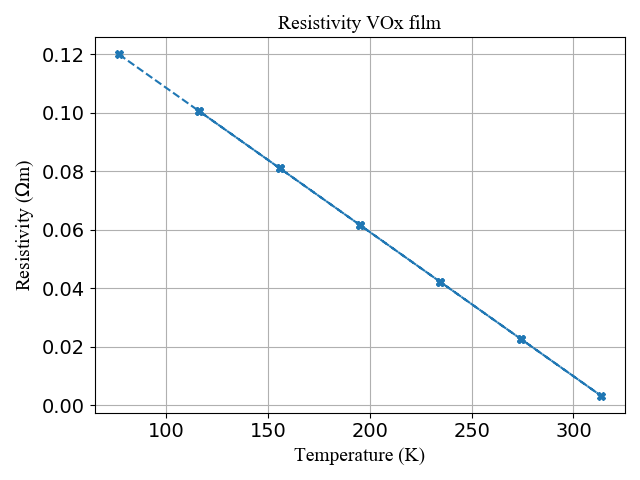

In [18]:
# Plot coating resistivity vs. temperature
%matplotlib notebook 

#T = np.arange(70,400,1)
T = np.copy(T_power_wo)


pf_LN = 0.12 # [Ohm m] VOx resistivity at 77 K (VALUE FOR TAPE 26)
pf_RT = 0.01 # [Ohm m] VO resitivity at room temperature ~ 294 K

pcu_RT = 1.68E-8 # [Ohm m] Cu resistivity 1.68E-8 at 300 K
pcu_LN = 0.2E-8 # [Ohm m] Cu resistivity 77 K

    
# Cu strip resistances
rho_cu_plot = resistivity_cu(T)
    
# VOx resistances
rho_vox_plot = resistivity_vox2(T,pf_LN,pf_RT)

#plt.plot(T,rho_cu_plot)
plt.plot(T,rho_vox_plot,'--X')


plt.xlabel('Temperature (K)',**axis_font)
plt.ylabel('Resistivity ($\Omega$m)',**axis_font)
plt.title(f'Resistivity VOx film',**axis_font)
#plt.legend(labelspacing=0.001,ncol=1,loc='best',prop={'family':'Times New Roman', 'size':10}) 
plt.tight_layout()
plt.grid()
#plt.savefig(f'w_currents_rc_t36_100e-6m_analyticT.png')
plt.show()

<IPython.core.display.Javascript object>


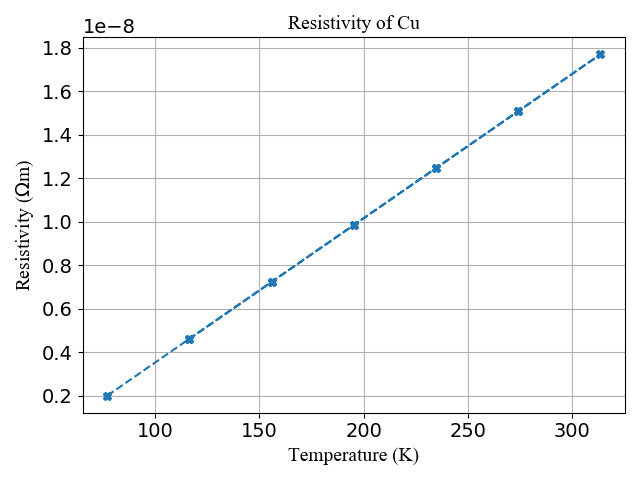

In [19]:
# Plot Cu resistivity vs. temperature 
%matplotlib notebook 


T = np.copy(T_power_wo)

pf_LN = 0.12 # [Ohm m] VOx resistivity at 77 K (VALUE FOR TAPE 26)
pf_RT = 0.01 # [Ohm m] VO resitivity at room temperature ~ 294 K

pcu_RT = 1.68E-8 # [Ohm m] Cu resistivity 1.68E-8 at 300 K
pcu_LN = 0.2E-8 # [Ohm m] Cu resistivity 77 K

    
# Cu strip resistances
rho_cu_plot = resistivity_cu(T)
    
# VOx resistances
rho_vox_plot = resistivity_vox2(T,pf_LN,pf_RT)

#plt.plot(T,rho_cu_plot)
plt.plot(T,rho_cu_plot,'--X')

#plt.ylim(-40,40)
plt.xlabel('Temperature (K)',**axis_font)
plt.ylabel('Resistivity ($\Omega$m)',**axis_font)
plt.title(f'Resistivity of Cu',**axis_font)
#plt.legend(labelspacing=0.001,ncol=1,loc='best',prop={'family':'Times New Roman', 'size':10}) 
plt.tight_layout()
plt.grid()
#plt.savefig(f'w_currents_rc_t36_100e-6m_analyticT.png')
plt.show()